## Index Components

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Import , Explore and Clean Company Listing data

In [3]:
nyse = pd.read_excel('../data/listings.xlsx' , sheet_name='nyse', na_values='n/a')
nyse.insert(0,"Exchange",'nyse', True)
amex = pd.read_excel('../data/listings.xlsx' , sheet_name='amex', na_values='n/a')
amex.insert(0,"Exchange",'amex', True)
nasdaq = pd.read_excel('../data/listings.xlsx' , sheet_name='nasdaq', na_values='n/a')
nasdaq.insert(0,"Exchange",'nasdaq', True)

listings = pd.concat([amex,nasdaq,nyse])
# convert Market Capitalization in millions of USD
listings['Market Capitalization'] = listings['Market Capitalization']/1000000

# Inspect listings using .info().
listings.info()

# Move the column 'Stock Symbol' into the index (inplace).
listings.set_index('Stock Symbol', inplace=True)

# Drop all companies with missing 'Sector' information from listings.
listings.dropna(subset=['Sector'], inplace=True)

# Select companies with IPO Year before 2019.
listings = listings[listings['IPO Year'] < 2019]

# Inspect the result of the changes you just made using .info()

listings.info()

# Show the number of companies per 'Sector' using .groupby() and .size(). Sort the output in descending order.
print(listings.groupby(['Sector']).size().sort_values(ascending=False))

C:\Python_Prac\timeseries_analysis\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Python_Prac\timeseries_analysis\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<class 'pandas.core.frame.DataFrame'>
Index: 6674 entries, 0 to 3146
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               6674 non-null   object 
 1   Stock Symbol           6674 non-null   object 
 2   Company Name           6674 non-null   object 
 3   Last Sale              6590 non-null   float64
 4   Market Capitalization  6674 non-null   float64
 5   IPO Year               2852 non-null   float64
 6   Sector                 5182 non-null   object 
 7   Industry               5182 non-null   object 
dtypes: float64(3), object(5)
memory usage: 469.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               2349 non-null   object 
 1   Company Name           2349 non-null   object 
 2   Last Sale 

C:\Python_Prac\timeseries_analysis\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Select and Inspect Index Component

In [4]:
# Use .groupby() and .nlargest() to select the largest company by 'Market Capitalization' for each 'Sector', and assign the result to components
components = listings.groupby(['Sector'])['Market Capitalization'].nlargest(1)

# Print components, sorted in descending order by market cap.
components = components.sort_values(ascending=False)

print(components)

# Select Stock Symbol from the index of components, assign it to tickers and print the result.
tickers =  components.index.get_level_values('Stock Symbol')

# Create a list info_cols that holds the column names Company Name, Market Capitalization, and Last Sale. Next, use .loc[] with tickers and info_cols 
# to print() more details about the listings sorted in descending order by Market Capitalization).
info_cols = ['Company Name','Market Capitalization','Last Sale']
print(listings.loc[tickers,info_cols])

Sector                 Stock Symbol
Technology             AAPL            740024.467000
Consumer Services      AMZN            422138.530626
Miscellaneous          BABA            275525.000000
Health Care            AMGN            118927.210535
Transportation         UPS              90180.886756
Finance                GS               88840.590477
Consumer Non-Durables  ABEV             88240.198455
Basic Industries       RIO              70431.476895
Public Utilities       TEF              54609.806092
Capital Goods          GM               50086.335099
Energy                 PAA              22223.001416
Consumer Durables      CPRT             13620.922869
Name: Market Capitalization, dtype: float64
                                    Company Name  Market Capitalization  \
Stock Symbol                                                              
AAPL                                  Apple Inc.          740024.467000   
AMZN                            Amazon.com, Inc.          4

### Import index component price information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None


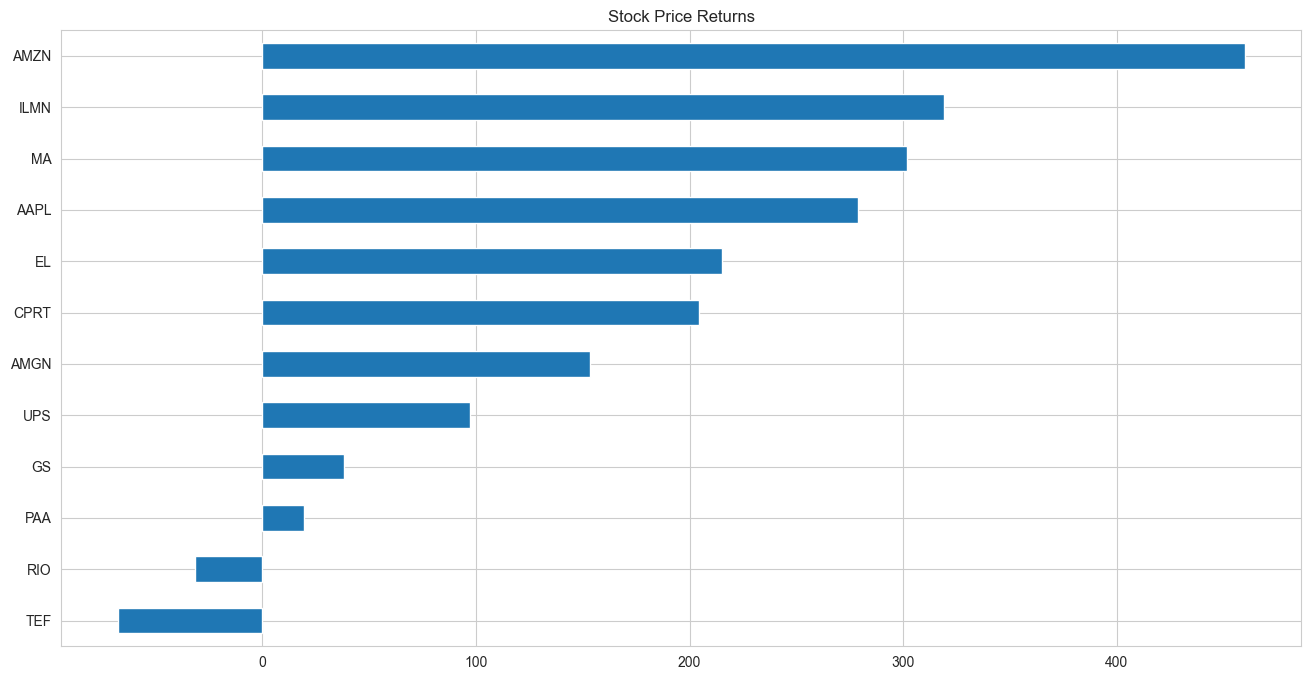

In [5]:
# Use pd.read_csv() to import 'stock_prices.csv', parsing the 'Date' column and also setting the 'Date' column as index before assigning the result to stock_prices. Inspect the result using .info()
stock_prices = pd.read_csv('../data/stock_data.csv', parse_dates=['Date'], index_col='Date')
print(stock_prices.info())

# Calculate the price return for the index components by dividing the last row of stock_prices by the first, subtracting 1 and multiplying by 100. Assign the result to price_return
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)

# Plot a horizontal bar chart of the sorted returns with the title Stock Price Returns.
price_return.sort_values().plot(kind='barh', title='Stock Price Returns', figsize=(16,8))
plt.show()

## Build a market-cap weighted index

### Calculate number of shares outstanding

In [6]:
# Inspect listings and print tickers
print(listings.info())
print(tickers)

# Use .loc[] with the list of tickers to select the index components and the columns 'Market Capitalization' and 'Last Sale'; assign this to components
components = listings.loc[tickers.tolist(),['Market Capitalization' ,'Last Sale']]

# Print the first five rows of components.
print(components.head())

# Create no_shares by dividing Market Capitalization by 'Last Sale'.
no_shares =  components['Market Capitalization'].div(components['Last Sale'])

components['Number of Shares'] = no_shares
# Print the sorted no_shares
print(no_shares.sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               2349 non-null   object 
 1   Company Name           2349 non-null   object 
 2   Last Sale              2349 non-null   float64
 3   Market Capitalization  2349 non-null   float64
 4   IPO Year               2349 non-null   float64
 5   Sector                 2349 non-null   object 
 6   Industry               2349 non-null   object 
dtypes: float64(3), object(4)
memory usage: 211.4+ KB
None
Index(['AAPL', 'AMZN', 'BABA', 'AMGN', 'UPS', 'GS', 'ABEV', 'RIO', 'TEF', 'GM',
       'PAA', 'CPRT'],
      dtype='object', name='Stock Symbol')
              Market Capitalization  Last Sale
Stock Symbol                                  
AAPL                  740024.467000     141.05
AMZN                  422138.530626     884.67
BABA                  275525.000000  

### Create time series of market value

Stock Symbol
GS        397.817439
CPRT      459.390316
AMZN      477.170618
PAA       723.404994
AMGN      735.890171
UPS       869.297154
GM       1500.039985
RIO      1808.717948
BABA     2500.000000
TEF      5037.804990
AAPL     5246.540000
ABEV    15701.102928
Name: Number of Shares, dtype: float64


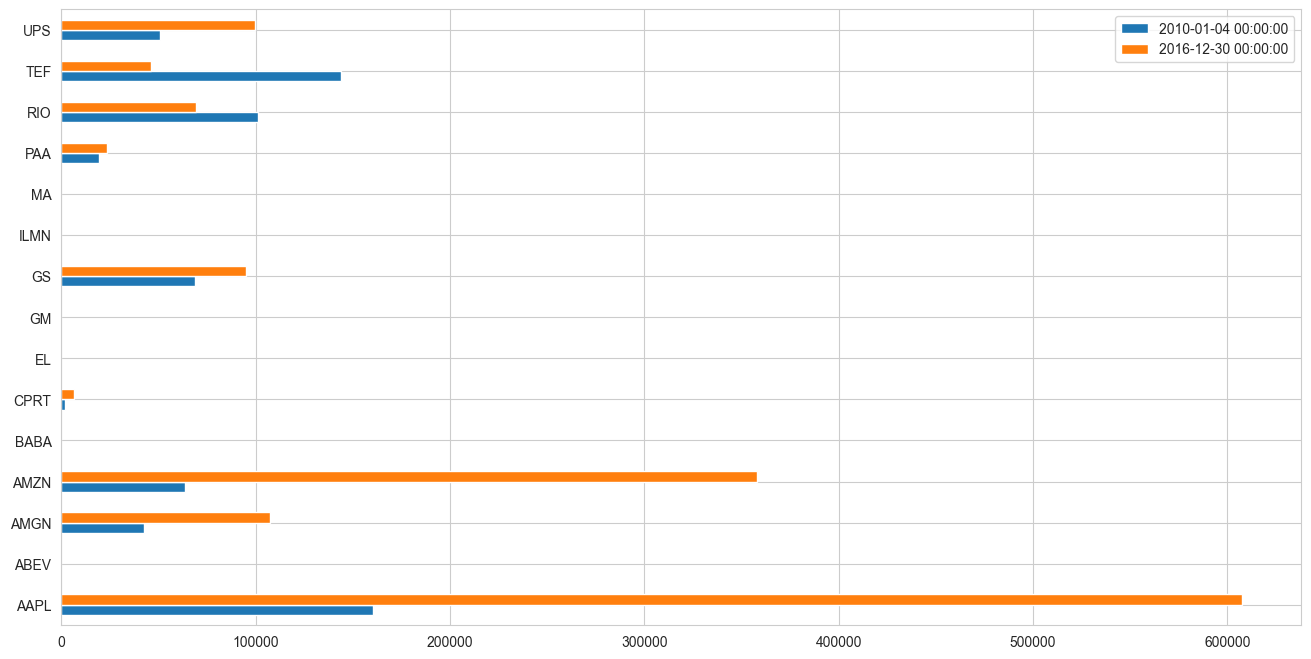

In [7]:
# Select the 'Number of Shares' from components, assign to no_shares, and print the result, sorted in the default (ascending) order.
# Select the number of shares
no_shares = components['Number of Shares']
print(no_shares.sort_values())

# Multiply stock_prices by no_shares to create a time series of market cap per ticker, and assign it to market_cap.
market_cap = stock_prices.mul(no_shares)

# Select the first and the last row of market_cap and assign these to first_value and last_value
first_value = market_cap.iloc[0]
last_value = market_cap.iloc[-1]

# Use pd.concat() to concatenate first_value and last_value along axis=1 and plot the result as horizontal bar chart.
pd.concat([first_value, last_value], axis=1).plot(kind='barh', figsize=(16,8))
plt.show()


### Calculate & plot the composite index

Date
2010-01-04    6.529794e+05
2010-01-05    6.562973e+05
2010-01-06    6.527435e+05
2010-01-07    6.492939e+05
2010-01-08    6.537965e+05
                  ...     
2016-12-23    1.425208e+06
2016-12-27    1.435541e+06
2016-12-28    1.431656e+06
2016-12-29    1.427209e+06
2016-12-30    1.413611e+06
Length: 1762, dtype: float64
Date
2010-01-04    100.000000
2010-01-05    100.508119
2010-01-06     99.963872
2010-01-07     99.435588
2010-01-08    100.125141
                 ...    
2016-12-23    218.262332
2016-12-27    219.844835
2016-12-28    219.249834
2016-12-29    218.568789
2016-12-30    216.486276
Length: 1762, dtype: float64


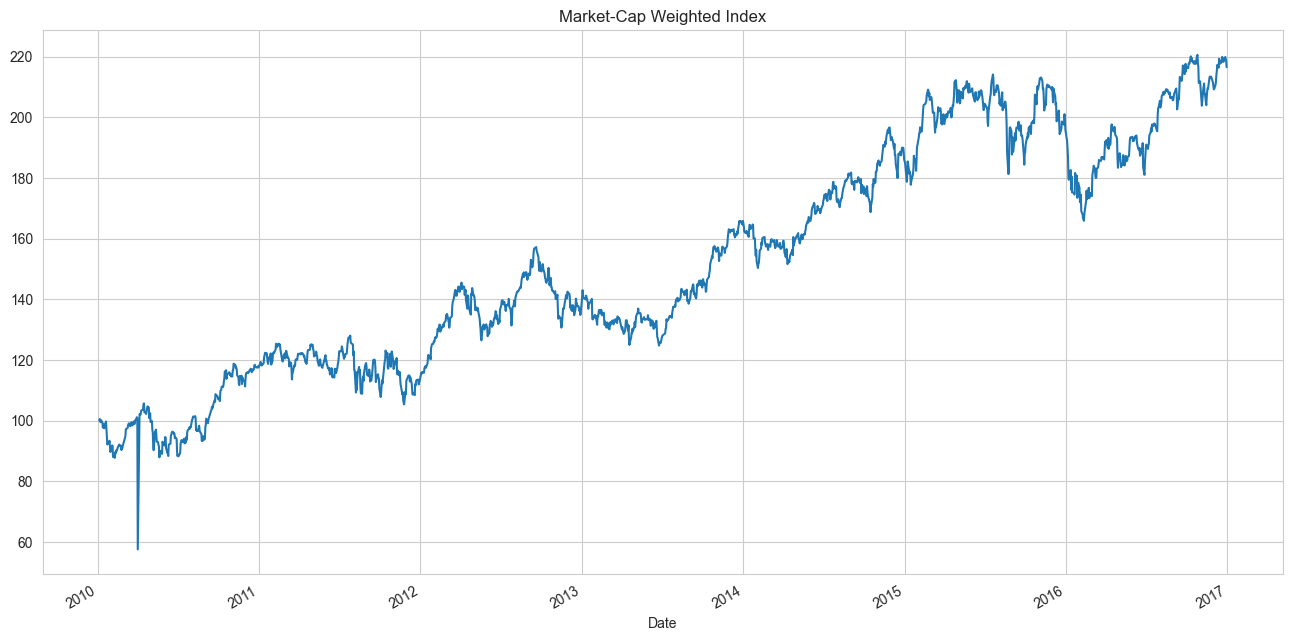

In [8]:
# Aggregate the market cap per trading day by applying .sum() to market_cap_series with axis=1, assign to raw_index and print the result.

raw_index = market_cap.sum(axis=1)
print(raw_index)

# Normalize the aggregate market cap by dividing by the first value of raw_index and multiplying by 100. Assign this to index and print the result.
index = raw_index.div(raw_index.iloc[0]).mul(100)
print(index)

# Plot the index with the title 'Market-Cap Weighted Index'.
index.plot(title='Market-Cap Weighted Index', figsize=(16,8))
plt.show()


## Evaluate Index Performance

### Calculate the contribution of each stock to the index

Stock Symbol
CPRT    0.006694
PAA     0.010921
GM      0.024614
TEF     0.026837
RIO     0.034613
ABEV    0.043365
GS      0.043660
UPS     0.044318
AMGN    0.058445
BABA    0.135403
AMZN    0.207455
AAPL    0.363675
Name: Market Capitalization, dtype: float64


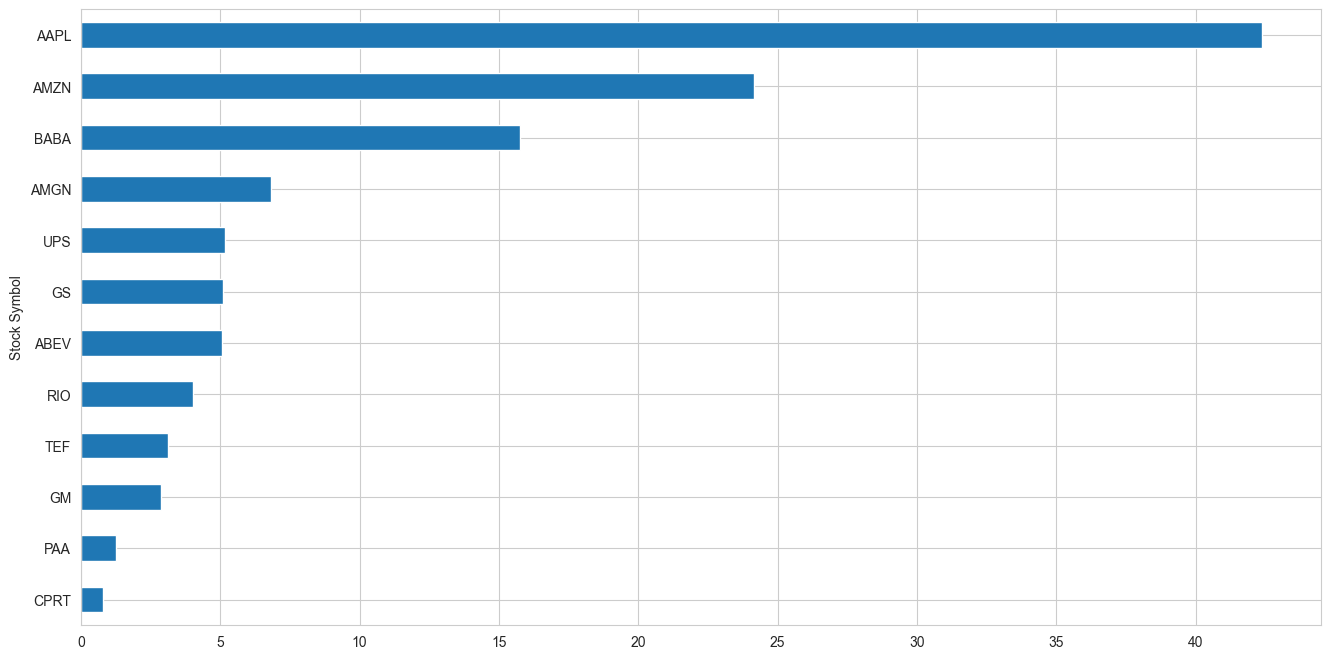

In [14]:
# Divide the last index value by the first, subtract 1 and multiply by 100. Assign the result to index_return and print it.
index_return = (index.iloc[-1]/index.iloc[0] - 1) * 100

# Select the 'Market Capitalization' column from components.
market_cap = components['Market Capitalization']

# Calculate the total market cap for all components and assign this to total_market_cap
total_market_cap = market_cap.sum()

# Divide the components' market cap by total_market_cap to calculate the component weights, assign it to weights, and print weights with the values sorted in default (ascending) order.
weights = market_cap.div(total_market_cap)
print(weights.sort_values())

# Multiply weights by the index_return to calculate the contribution by component, sort the values in ascending order, and plot the result as a horizontal bar chart.
weights.mul(index_return).sort_values().plot(kind='barh', figsize=(16,8))
plt.show()

### Compare index performance against benchmark

Index    116.486276
DJIA      86.722172
dtype: float64


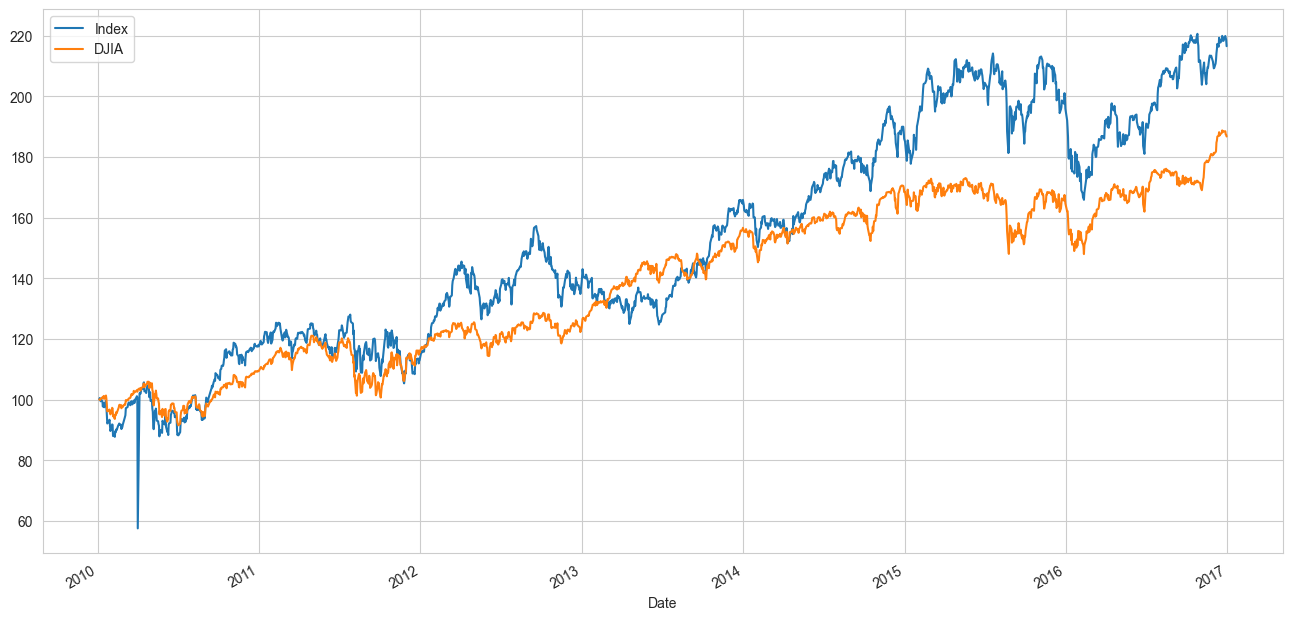

In [30]:
# Load djia data as pandas series
djia1 = pd.read_csv('../data/djia2.csv', parse_dates=['DATE'], index_col='DATE')
djia = djia1.iloc[:,0].squeeze()

# Convert index to a pd.DataFrame with the column name 'Index' and assign the result to data
data = index.to_frame('Index')

# Normalize djia to start at 100 and add it as new column to data.
djia = djia.div(djia.iloc[0],axis=0).mul(100)
data['DJIA'] = djia

# Show the total return for both index and djia by dividing the last row of data by the first, subtracting 1 and multiplying by 100.
print(data.iloc[-1].div(data.iloc[0]).sub(1).mul(100))

# Plot both series
data.plot(figsize=(16,8))
plt.show()


### Compare index performance against benchmark II

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1762 non-null   float64
 1   DJIA    1762 non-null   float64
dtypes: float64(2)
memory usage: 41.3 KB
None
                 Index      DJIA
Date                            
2010-01-04  100.000000  10583.96
2010-01-05  100.508119  10572.02
2010-01-06   99.963872  10573.68
2010-01-07   99.435588  10606.86
2010-01-08  100.125141  10618.19


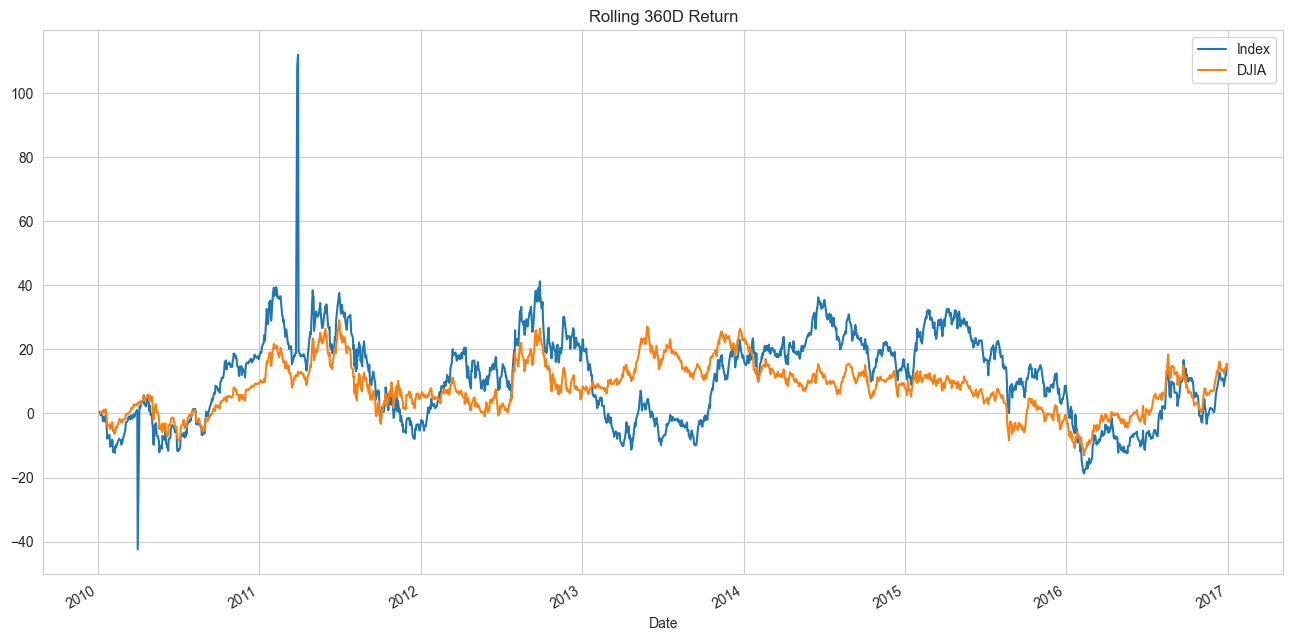

In [38]:
# Load dow jones data
dj = pd.read_csv('../data/dow_jones.csv', parse_dates=['date'], index_col='date')

# Join index and dow jones data
data = index.to_frame('Index').join(dj)

# Inspect data and print the first five rows.
print(data.info())
print(data.head())

# Define a function multi_period_return that takes a numpy array of period returns as input, and returns the total return for the period. 
# Use the formula from the video - add 1 to the input, pass the result to np.prod(), subtract 1 and multiply by 100.

def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100

# Create a .rolling() window of length '360D' from data, and apply multi_period_return. Assign to rolling_return_360
rolling_return_360 = data.pct_change().rolling('360D').apply(multi_period_return)

# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return', figsize=(16,8))
plt.show()

## Index Corelation

### Visualize your index constituent correlations

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None
          AAPL      AMGN      AMZN      CPRT        EL        GS      ILMN  \
AAPL  1.000000  0.286897  0.327609  0.346615  0.307203  0.344936  0.264790   
AMGN  0.286897  1.000000  0.323407  0.355891  0.350240  0.390056  0.336926   
AMZN  0.327609  0.323407  1.000000  0.298928  0.333545  0.333555  0.242725 

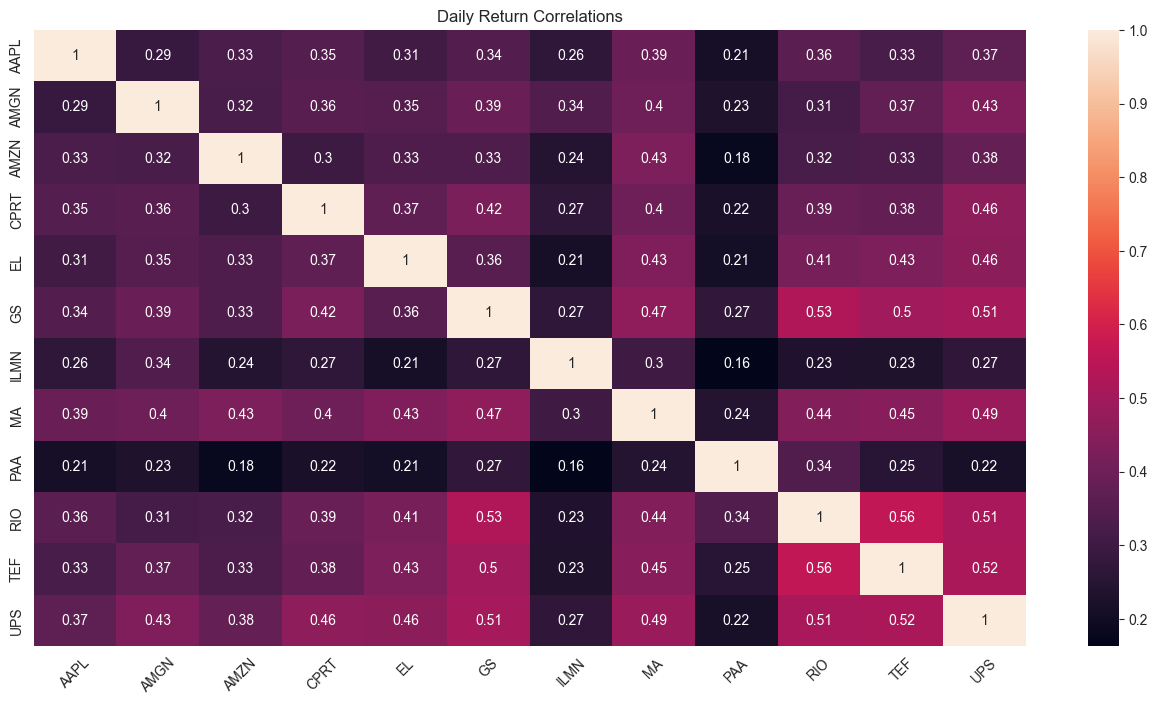

In [44]:
# Load stock data
stock_prices = pd.read_csv('../data/stock_data.csv', parse_dates=['Date'], index_col='Date')

# Inspect stock_prices using .info()
print(stock_prices.info())

# Calculate the daily returns for stock_prices and assign the result to returns
returns = stock_prices.dropna().pct_change()

# Calculate the pairwise correlations for returns, assign them to correlations and print the result.
correlations = returns.corr()
print(correlations)

# Plot a heatmap of daily return correlations
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(correlations, annot=True, ax=ax)
plt.xticks(rotation=45)
plt.title('Daily Return Correlations')
plt.show()

### Save your analysis to multiple excel worksheets

In [52]:
#Inspect both index and stock_prices using .info().
print(index.info())
print(stock_prices.info())

# Use .join() to combine index with stock_prices, and assign to data.
data = index.to_frame('Index').join(stock_prices)

# Apply .pct_change() to data and assign to returns.
returns = data.dropna().pct_change()

# Create pd.ExcelWriter and use with to export data and returns to excel with sheet_names of the same name.
with pd.ExcelWriter('../data/data.xlsx') as writer:
    data.to_excel(excel_writer=writer, sheet_name='data')
    returns.to_excel(excel_writer=writer, sheet_name='returns')


<class 'pandas.core.series.Series'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Series name: None
Non-Null Count  Dtype  
--------------  -----  
1762 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None
